# Order of magnitude faster training for image classification: Part II

### _Transfer learning using Inception Package - Cloud Run Experience_
This notebook continues the codifies the capabilities discussed in this [blog post](http://localhost:8081/). In a nutshell, it uses the pre-trained inception model as a starting point and then uses transfer learning to train it further on additional, customer-specific images. For explanation, simple flower images are used. Compared to training from scratch, the time and costs are drastically reduced.

This notebook does preprocessing, training and prediction by calling CloudML API instead of running them in the Datalab container.  The purpose of local work is to do some initial prototyping and debugging on small scale data - often by taking a suitable (say 0.1 - 1%) sample of the full data. The same basic steps can then be repeated with much larger datasets in cloud.

## Setup 

First run the following steps only if you are running Datalab from your local desktop or laptop (not running Datalab from a GCE VM):

1. Make sure you have a GCP project which is enabled for Machine Learning API and Dataflow API.
2. Sign in with Datalab on the top right corner.
3. Run "%projects set [project-id]" to set the default project in Datalab.
4. Run "!gcloud config set project [project-id]"

Then, regardless of where you run Datalab, please run:

!gcloud beta ml init-project -q

In [3]:
!gcloud beta ml init-project -q

Added serviceAccount:cloud-ml-service@datalab-beta-golden-83755.iam.gserviceaccount.com as an Editor to project 'datalab-beta-golden'.


In [1]:
from datalab_solutions.inception import *
from datalab.ml import *

bucket = 'gs://' + datalab_project_id() + '-lab'
preprocess_dir = bucket + '/flowerpreprocessedcloud'
model_dir = bucket + '/flowermodelcloud'
staging_dir = bucket + '/staging'

In [3]:
!gsutil mb $bucket

Creating gs://bradley-playground-lab/...


## Preprocess
Preprocessing uses a Dataflow pipeline to convert the image format, resize images, and run the converted image through a pre-trained model to get the features or embeddings. You can also do this step using alternate technologies like Spark or plain Python code if you like. 
The %%ml preprocess command simplifies this task. Check out the parameters shown using --usage flag first and then run the command.

If you hit "PERMISSION_DENIED" when running the following cell, you need to enable Cloud DataFlow API (url is shown in error message). 

The DataFlow job usually takes about 20 min to complete.

In [4]:
train_set = CsvDataSet('gs://cloud-datalab/sampledata/flower/train1000.csv', schema='image_url:STRING,label:STRING')
cloud_preprocess(train_set, preprocess_dir, pipeline_option={'num_workers': 10})

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning:

Using fallback coder for typehint: Any.



Job "preprocess-inception-170216-013812" submitted. Click here to track preprocessing job.

## Train
Note that the command remains the same as that in the "local" version.

In [2]:
cloud_train(preprocess_dir, 30, 1000, model_dir, CloudTrainingConfig('us-central1', 'BASIC'))

Job "inception_train_170216_185127" submitted. Click here to view cloud log.

Check your job status.

In [3]:
Job('inception_train_170216_185127').describe()

createTime: '2017-02-16T18:51:29Z'
jobId: inception_train_170216_185127
state: PREPARING
trainingInput:
  args:
  - --checkpoint
  - gs://cloud-ml-data/img/flower_photos/inception_v3_2016_08_28.ckpt
  - --input_dir
  - gs://bradley-playground-lab/flowerpreprocessedcloud
  - --max_steps
  - '1000'
  - --output_path
  - gs://bradley-playground-lab/flowermodelcloud
  - --batch_size
  - '30'
  packageUris:
  - gs://cloud-datalab/deploy/tf/tensorflow-1.0.0rc1-cp27-none-linux_x86_64.whl
  - gs://bradley-playground-lab/flowermodelcloud/staging/inception.tar.gz
  pythonModule: datalab_solutions.inception.task
  region: us-central1
trainingOutput: {}



Tensorboard works too with GCS path.

In [6]:
TensorBoard().start(model_dir)

TensorBoard was started successfully with pid 13270. Click here to access it.

## Predict
Deploy the model and run online predictions. The deployment takes about 2 ~ 5 minutes. 

In [7]:
Models().create('flower')
ModelVersions('flower').deploy('beta1', model_dir)

Waiting for operation "projects/bradley-playground/operations/create_flower_beta1-1487272536957"
Done.


Online prediction is currently in alpha, it helps to ensure a warm start if the first call fails.

Predicting...


daisy(0.99996)

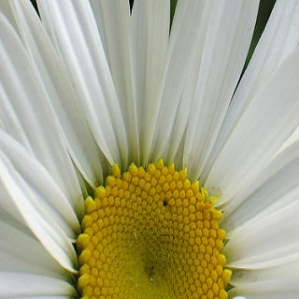

tulips(0.99999)

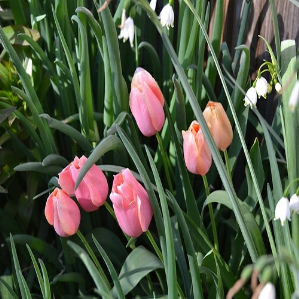

Done


In [3]:
images = [
    'gs://cloud-ml-data/img/flower_photos/daisy/15207766_fc2f1d692c_n.jpg',
    'gs://cloud-ml-data/img/flower_photos/tulips/6876631336_54bf150990.jpg'
]
# set resize=True to avoid sending large data in prediction request.
cloud_predict('flower.beta1', images, resize=True)

## Batch Predict

In [3]:
eval_set = CsvDataSet('gs://cloud-datalab/sampledata/flower/eval670.csv', schema='image_url:STRING,label:STRING')
cloud_batch_predict(eval_set, model_dir, staging_dir, output_bq_table='flower.eval_results_full')

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning:

Using fallback coder for typehint: Any.



Job "batch-predict-inception-170216-194904" submitted. Click here to track batch prediction job.

In [4]:
%%sql
select * from flower.eval_results_full where target != predicted

image_url,target,predicted,target_prob,predicted_prob
gs://cloud-ml-data/img/flower_photos/roses/5212877807_a3ddf06a7c_n.jpg,roses,daisy,8.70141320775e-06,0.98399156332
gs://cloud-ml-data/img/flower_photos/tulips/5757091018_cdfd79dfa6_m.jpg,tulips,daisy,0.000795748550445,0.997746407986
gs://cloud-ml-data/img/flower_photos/dandelion/13386618495_3df1f1330d.jpg,dandelion,daisy,0.000394038070226,0.999532938004
gs://cloud-ml-data/img/flower_photos/dandelion/2598486434_bf349854f2_m.jpg,dandelion,daisy,0.446149975061,0.550196826458
gs://cloud-ml-data/img/flower_photos/dandelion/2401343175_d2a892cf25_n.jpg,dandelion,daisy,0.00885738898069,0.987739145756
gs://cloud-ml-data/img/flower_photos/dandelion/139124974_9e3ba69f6c.jpg,dandelion,daisy,0.0733262076974,0.907573759556
gs://cloud-ml-data/img/flower_photos/sunflowers/7804213238_1d92ae5edb_m.jpg,sunflowers,daisy,0.404097318649,0.59275829792
gs://cloud-ml-data/img/flower_photos/sunflowers/21984860006_20dfacea1c_m.jpg,sunflowers,daisy,0.00429367832839,0.995241641998
gs://cloud-ml-data/img/flower_photos/sunflowers/9461693602_710f20904f.jpg,sunflowers,daisy,0.0251664444804,0.974599540234
gs://cloud-ml-data/img/flower_photos/sunflowers/19349582128_68a662075e_n.jpg,sunflowers,daisy,0.137781515718,0.848658144474


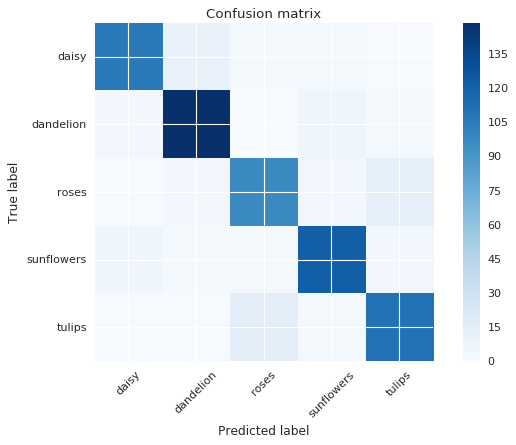

In [5]:
ConfusionMatrix.from_bigquery('flower.eval_results_full').plot()

In [2]:
%%sql --module accuracy
SELECT
  target,
  SUM(CASE WHEN target == predicted THEN 1 ELSE 0 END) as correct,
  COUNT(*) as total,
  SUM(CASE WHEN target == predicted THEN 1 ELSE 0 END)/COUNT(*) as accuracy,
FROM
  flower.eval_results_full
GROUP BY
  target

In [3]:
%%bigquery execute -q accuracy

target,correct,total,accuracy
daisy,110,122,0.901639344262
roses,93,119,0.781512605042
tulips,113,130,0.869230769231
dandelion,144,162,0.888888888889
sunflowers,126,137,0.919708029197


In [12]:
%%sql --module logloss

SELECT feature, AVG(-logloss) as logloss, count(*) as count FROM
(
SELECT feature, CASE WHEN correct == 1 THEN LOG(prob) ELSE LOG(1-prob) END as logloss,
FROM
(
SELECT
target as feature, 
CASE WHEN target == predicted THEN 1 ELSE 0 END as correct,
target_prob as prob
FROM flower.eval_results_full))
GROUP BY feature

In [13]:
FeatureSliceView().plot(logloss)